## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import time
from keras import losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import Adadelta, SGD, Adam
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from IPython.display import SVG
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


## Importing data from CSVs.

In [2]:
features_data = pd.read_csv("15features.csv")
training_data = pd.read_csv("shuffled-dataset/dataset_shuffled_training_siamese.csv")
validation_data = pd.read_csv("shuffled-dataset/dataset_shuffled_validation_siamese.csv")

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)

train_path = 'shuffled-dataset/TrainingSet/'
train_images = os.listdir(train_path)
#print(len(train_images))
val_path = 'shuffled-dataset/ValidationSet/'
val_images = os.listdir(val_path)

columns = features_data.columns

#Get the unique no of values a given feature can take.
features_values = []
for i in columns[1:]:
    #print(i)
    features_values.append(features_data[i].unique().shape[0])
features_values

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

## Datagen

In [3]:
def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
            writer = list_of_writers[writer_index] 
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            counter+=1
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0

## AutoEncoder

In [4]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_

##  Generators

In [5]:
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

training_datagen = datagen(batch_size,train_path,train_list_of_writers, hshift = (-10,10))
validation_datagen = datagen(batch_size,val_path,val_list_of_writers, hshift = (-10,10))

## SVG

In [6]:
#SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## Model Checkpoint and Early Stopping

In [7]:
mc = ModelCheckpoint(filepath='saved_model_shuffled_mc.h5', 
                     monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

## Fitting the generator

In [8]:
EPOCHS = 5000

hist = autoencoder.fit_generator(training_datagen,
                                 callbacks=[mc,es],
                                 epochs=EPOCHS,
                                 steps_per_epoch = 1,
                                 validation_data = validation_datagen,
                                 validation_steps = 1,
                                 verbose = 3)
autoencoder.save_weights("saved_model_shuffled_mc.h5")
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5000

Epoch 00001: val_loss improved from inf to 0.69173, saving model to saved_model_shuffled_mc.h5
Epoch 2/5000

Epoch 00002: val_loss improved from 0.69173 to 0.68822, saving model to saved_model_shuffled_mc.h5
Epoch 3/5000

Epoch 00003: val_loss improved from 0.68822 to 0.68309, saving model to saved_model_shuffled_mc.h5
Epoch 4/5000

Epoch 00004: val_loss improved from 0.68309 to 0.67512, saving model to saved_model_shuffled_mc.h5
Epoch 5/5000

Epoch 00005: val_loss improved from 0.67512 to 0.66171, saving model to saved_model_shuffled_mc.h5
Epoch 6/5000

Epoch 00006: val_loss improved from 0.66171 to 0.63586, saving model to saved_model_shuffled_mc.h5
Epoch 7/5000

Epoch 00007: val_loss improved from 0.63586 to 0.57645, saving model to saved_model_shuffled_mc.h5
Epoch 8/5000

Epoch 00008: val_loss improved from 0.57645 to 0.42390, saving model to saved_model_shuffled_mc.h5
Epoch 9/5000

Epoch 00009: val_loss did not improve 

Epoch 00099: val_loss did not improve from 0.19716
Epoch 100/5000

Epoch 00100: val_loss did not improve from 0.19716
Epoch 101/5000

Epoch 00101: val_loss did not improve from 0.19716
Epoch 102/5000

Epoch 00102: val_loss did not improve from 0.19716
Epoch 103/5000

Epoch 00103: val_loss did not improve from 0.19716
Epoch 104/5000

Epoch 00104: val_loss improved from 0.19716 to 0.19648, saving model to saved_model_shuffled_mc.h5
Epoch 105/5000

Epoch 00105: val_loss did not improve from 0.19648
Epoch 106/5000

Epoch 00106: val_loss did not improve from 0.19648
Epoch 107/5000

Epoch 00107: val_loss improved from 0.19648 to 0.19539, saving model to saved_model_shuffled_mc.h5
Epoch 108/5000

Epoch 00108: val_loss did not improve from 0.19539
Epoch 109/5000

Epoch 00109: val_loss did not improve from 0.19539
Epoch 110/5000

Epoch 00110: val_loss did not improve from 0.19539
Epoch 111/5000

Epoch 00111: val_loss did not improve from 0.19539
Epoch 112/5000

Epoch 00112: val_loss did not imp

Epoch 00217: val_loss did not improve from 0.18989
Epoch 218/5000

Epoch 00218: val_loss did not improve from 0.18989
Epoch 219/5000

Epoch 00219: val_loss did not improve from 0.18989
Epoch 220/5000

Epoch 00220: val_loss did not improve from 0.18989
Epoch 221/5000

Epoch 00221: val_loss did not improve from 0.18989
Epoch 222/5000

Epoch 00222: val_loss did not improve from 0.18989
Epoch 223/5000

Epoch 00223: val_loss did not improve from 0.18989
Epoch 224/5000

Epoch 00224: val_loss did not improve from 0.18989
Epoch 225/5000

Epoch 00225: val_loss did not improve from 0.18989
Epoch 226/5000

Epoch 00226: val_loss did not improve from 0.18989
Epoch 227/5000

Epoch 00227: val_loss did not improve from 0.18989
Epoch 228/5000

Epoch 00228: val_loss did not improve from 0.18989
Epoch 229/5000

Epoch 00229: val_loss did not improve from 0.18989
Epoch 230/5000

Epoch 00230: val_loss did not improve from 0.18989
Epoch 231/5000

Epoch 00231: val_loss did not improve from 0.18989
Epoch 232/5

Epoch 00337: val_loss did not improve from 0.18711
Epoch 338/5000

Epoch 00338: val_loss did not improve from 0.18711
Epoch 339/5000

Epoch 00339: val_loss did not improve from 0.18711
Epoch 340/5000

Epoch 00340: val_loss did not improve from 0.18711
Epoch 341/5000

Epoch 00341: val_loss did not improve from 0.18711
Epoch 342/5000

Epoch 00342: val_loss did not improve from 0.18711
Epoch 343/5000

Epoch 00343: val_loss did not improve from 0.18711
Epoch 344/5000

Epoch 00344: val_loss did not improve from 0.18711
Epoch 345/5000

Epoch 00345: val_loss did not improve from 0.18711
Epoch 346/5000

Epoch 00346: val_loss did not improve from 0.18711
Epoch 347/5000

Epoch 00347: val_loss did not improve from 0.18711
Epoch 348/5000

Epoch 00348: val_loss did not improve from 0.18711
Epoch 349/5000

Epoch 00349: val_loss did not improve from 0.18711
Epoch 350/5000

Epoch 00350: val_loss did not improve from 0.18711
Epoch 351/5000

Epoch 00351: val_loss did not improve from 0.18711
Epoch 352/5

Epoch 00456: val_loss did not improve from 0.18244
Epoch 457/5000

Epoch 00457: val_loss did not improve from 0.18244
Epoch 458/5000

Epoch 00458: val_loss did not improve from 0.18244
Epoch 459/5000

Epoch 00459: val_loss did not improve from 0.18244
Epoch 460/5000

Epoch 00460: val_loss did not improve from 0.18244
Epoch 461/5000

Epoch 00461: val_loss did not improve from 0.18244
Epoch 462/5000

Epoch 00462: val_loss did not improve from 0.18244
Epoch 463/5000

Epoch 00463: val_loss did not improve from 0.18244
Epoch 464/5000

Epoch 00464: val_loss did not improve from 0.18244
Epoch 465/5000

Epoch 00465: val_loss improved from 0.18244 to 0.18030, saving model to saved_model_shuffled_mc.h5
Epoch 466/5000

Epoch 00466: val_loss did not improve from 0.18030
Epoch 467/5000

Epoch 00467: val_loss did not improve from 0.18030
Epoch 468/5000

Epoch 00468: val_loss did not improve from 0.18030
Epoch 469/5000

Epoch 00469: val_loss did not improve from 0.18030
Epoch 470/5000

Epoch 00470: v

Epoch 00576: val_loss did not improve from 0.17771
Epoch 577/5000

Epoch 00577: val_loss did not improve from 0.17771
Epoch 578/5000

Epoch 00578: val_loss did not improve from 0.17771
Epoch 579/5000

Epoch 00579: val_loss did not improve from 0.17771
Epoch 580/5000

Epoch 00580: val_loss did not improve from 0.17771
Epoch 581/5000

Epoch 00581: val_loss did not improve from 0.17771
Epoch 582/5000

Epoch 00582: val_loss did not improve from 0.17771
Epoch 583/5000

Epoch 00583: val_loss did not improve from 0.17771
Epoch 584/5000

Epoch 00584: val_loss did not improve from 0.17771
Epoch 585/5000

Epoch 00585: val_loss did not improve from 0.17771
Epoch 586/5000

Epoch 00586: val_loss did not improve from 0.17771
Epoch 587/5000

Epoch 00587: val_loss did not improve from 0.17771
Epoch 588/5000

Epoch 00588: val_loss did not improve from 0.17771
Epoch 589/5000

Epoch 00589: val_loss did not improve from 0.17771
Epoch 590/5000

Epoch 00590: val_loss did not improve from 0.17771
Epoch 591/5

Epoch 00696: val_loss did not improve from 0.17349
Epoch 697/5000

Epoch 00697: val_loss did not improve from 0.17349
Epoch 698/5000

Epoch 00698: val_loss did not improve from 0.17349
Epoch 699/5000

Epoch 00699: val_loss did not improve from 0.17349
Epoch 700/5000

Epoch 00700: val_loss did not improve from 0.17349
Epoch 701/5000

Epoch 00701: val_loss did not improve from 0.17349
Epoch 702/5000

Epoch 00702: val_loss did not improve from 0.17349
Epoch 703/5000

Epoch 00703: val_loss did not improve from 0.17349
Epoch 704/5000

Epoch 00704: val_loss did not improve from 0.17349
Epoch 705/5000

Epoch 00705: val_loss did not improve from 0.17349
Epoch 706/5000

Epoch 00706: val_loss did not improve from 0.17349
Epoch 707/5000

Epoch 00707: val_loss did not improve from 0.17349
Epoch 708/5000

Epoch 00708: val_loss did not improve from 0.17349
Epoch 709/5000

Epoch 00709: val_loss did not improve from 0.17349
Epoch 710/5000

Epoch 00710: val_loss did not improve from 0.17349
Epoch 711/5

Epoch 817/5000

Epoch 00817: val_loss did not improve from 0.17273
Epoch 818/5000

Epoch 00818: val_loss did not improve from 0.17273
Epoch 819/5000

Epoch 00819: val_loss did not improve from 0.17273
Epoch 820/5000

Epoch 00820: val_loss did not improve from 0.17273
Epoch 821/5000

Epoch 00821: val_loss improved from 0.17273 to 0.17191, saving model to saved_model_shuffled_mc.h5
Epoch 822/5000

Epoch 00822: val_loss did not improve from 0.17191
Epoch 823/5000

Epoch 00823: val_loss did not improve from 0.17191
Epoch 824/5000

Epoch 00824: val_loss did not improve from 0.17191
Epoch 825/5000

Epoch 00825: val_loss did not improve from 0.17191
Epoch 826/5000

Epoch 00826: val_loss did not improve from 0.17191
Epoch 827/5000

Epoch 00827: val_loss did not improve from 0.17191
Epoch 828/5000

Epoch 00828: val_loss did not improve from 0.17191
Epoch 829/5000

Epoch 00829: val_loss did not improve from 0.17191
Epoch 830/5000

Epoch 00830: val_loss did not improve from 0.17191
Epoch 831/5000

Epoch 937/5000

Epoch 00937: val_loss did not improve from 0.17103
Epoch 938/5000

Epoch 00938: val_loss did not improve from 0.17103
Epoch 939/5000

Epoch 00939: val_loss did not improve from 0.17103
Epoch 940/5000

Epoch 00940: val_loss did not improve from 0.17103
Epoch 941/5000

Epoch 00941: val_loss did not improve from 0.17103
Epoch 942/5000

Epoch 00942: val_loss did not improve from 0.17103
Epoch 943/5000

Epoch 00943: val_loss did not improve from 0.17103
Epoch 944/5000

Epoch 00944: val_loss did not improve from 0.17103
Epoch 945/5000

Epoch 00945: val_loss did not improve from 0.17103
Epoch 946/5000

Epoch 00946: val_loss did not improve from 0.17103
Epoch 947/5000

Epoch 00947: val_loss did not improve from 0.17103
Epoch 948/5000

Epoch 00948: val_loss did not improve from 0.17103
Epoch 949/5000

Epoch 00949: val_loss did not improve from 0.17103
Epoch 950/5000

Epoch 00950: val_loss did not improve from 0.17103
Epoch 951/5000

Epoch 00951: val_loss did not improve from 0.1

Epoch 1057/5000

Epoch 01057: val_loss did not improve from 0.16853
Epoch 1058/5000

Epoch 01058: val_loss did not improve from 0.16853
Epoch 1059/5000

Epoch 01059: val_loss did not improve from 0.16853
Epoch 1060/5000

Epoch 01060: val_loss did not improve from 0.16853
Epoch 1061/5000

Epoch 01061: val_loss did not improve from 0.16853
Epoch 1062/5000

Epoch 01062: val_loss did not improve from 0.16853
Epoch 1063/5000

Epoch 01063: val_loss did not improve from 0.16853
Epoch 1064/5000

Epoch 01064: val_loss did not improve from 0.16853
Epoch 1065/5000

Epoch 01065: val_loss did not improve from 0.16853
Epoch 1066/5000

Epoch 01066: val_loss did not improve from 0.16853
Epoch 1067/5000

Epoch 01067: val_loss did not improve from 0.16853
Epoch 1068/5000

Epoch 01068: val_loss did not improve from 0.16853
Epoch 1069/5000

Epoch 01069: val_loss did not improve from 0.16853
Epoch 1070/5000

Epoch 01070: val_loss did not improve from 0.16853
Epoch 1071/5000

Epoch 01071: val_loss did not i

Epoch 01176: val_loss did not improve from 0.16548
Epoch 1177/5000

Epoch 01177: val_loss did not improve from 0.16548
Epoch 1178/5000

Epoch 01178: val_loss did not improve from 0.16548
Epoch 1179/5000

Epoch 01179: val_loss did not improve from 0.16548
Epoch 1180/5000

Epoch 01180: val_loss did not improve from 0.16548
Epoch 1181/5000

Epoch 01181: val_loss did not improve from 0.16548
Epoch 1182/5000

Epoch 01182: val_loss did not improve from 0.16548
Epoch 1183/5000

Epoch 01183: val_loss did not improve from 0.16548
Epoch 1184/5000

Epoch 01184: val_loss did not improve from 0.16548
Epoch 1185/5000

Epoch 01185: val_loss did not improve from 0.16548
Epoch 1186/5000

Epoch 01186: val_loss did not improve from 0.16548
Epoch 1187/5000

Epoch 01187: val_loss did not improve from 0.16548
Epoch 1188/5000

Epoch 01188: val_loss did not improve from 0.16548
Epoch 1189/5000

Epoch 01189: val_loss did not improve from 0.16548
Epoch 1190/5000

Epoch 01190: val_loss did not improve from 0.165

Epoch 01296: val_loss did not improve from 0.16548
Epoch 1297/5000

Epoch 01297: val_loss did not improve from 0.16548
Epoch 1298/5000

Epoch 01298: val_loss did not improve from 0.16548
Epoch 1299/5000

Epoch 01299: val_loss did not improve from 0.16548
Epoch 1300/5000

Epoch 01300: val_loss did not improve from 0.16548
Epoch 1301/5000

Epoch 01301: val_loss did not improve from 0.16548
Epoch 1302/5000

Epoch 01302: val_loss did not improve from 0.16548
Epoch 1303/5000

Epoch 01303: val_loss did not improve from 0.16548
Epoch 1304/5000

Epoch 01304: val_loss improved from 0.16548 to 0.16468, saving model to saved_model_shuffled_mc.h5
Epoch 1305/5000

Epoch 01305: val_loss improved from 0.16468 to 0.16422, saving model to saved_model_shuffled_mc.h5
Epoch 1306/5000

Epoch 01306: val_loss did not improve from 0.16422
Epoch 1307/5000

Epoch 01307: val_loss did not improve from 0.16422
Epoch 1308/5000

Epoch 01308: val_loss did not improve from 0.16422
Epoch 1309/5000

Epoch 01309: val_los

Epoch 1413/5000

Epoch 01413: val_loss did not improve from 0.16190
Epoch 1414/5000

Epoch 01414: val_loss did not improve from 0.16190
Epoch 1415/5000

Epoch 01415: val_loss did not improve from 0.16190
Epoch 1416/5000

Epoch 01416: val_loss did not improve from 0.16190
Epoch 1417/5000

Epoch 01417: val_loss did not improve from 0.16190
Epoch 1418/5000

Epoch 01418: val_loss did not improve from 0.16190
Epoch 1419/5000

Epoch 01419: val_loss did not improve from 0.16190
Epoch 1420/5000

Epoch 01420: val_loss did not improve from 0.16190
Epoch 1421/5000

Epoch 01421: val_loss did not improve from 0.16190
Epoch 1422/5000

Epoch 01422: val_loss did not improve from 0.16190
Epoch 1423/5000

Epoch 01423: val_loss did not improve from 0.16190
Epoch 1424/5000

Epoch 01424: val_loss did not improve from 0.16190
Epoch 1425/5000

Epoch 01425: val_loss did not improve from 0.16190
Epoch 1426/5000

Epoch 01426: val_loss did not improve from 0.16190
Epoch 1427/5000

Epoch 01427: val_loss did not i

Epoch 01532: val_loss did not improve from 0.16185
Epoch 1533/5000

Epoch 01533: val_loss did not improve from 0.16185
Epoch 1534/5000

Epoch 01534: val_loss did not improve from 0.16185
Epoch 1535/5000

Epoch 01535: val_loss did not improve from 0.16185
Epoch 1536/5000

Epoch 01536: val_loss did not improve from 0.16185
Epoch 1537/5000

Epoch 01537: val_loss did not improve from 0.16185
Epoch 1538/5000

Epoch 01538: val_loss did not improve from 0.16185
Epoch 1539/5000

Epoch 01539: val_loss did not improve from 0.16185
Epoch 1540/5000

Epoch 01540: val_loss did not improve from 0.16185
Epoch 1541/5000

Epoch 01541: val_loss did not improve from 0.16185
Epoch 1542/5000

Epoch 01542: val_loss did not improve from 0.16185
Epoch 1543/5000

Epoch 01543: val_loss did not improve from 0.16185
Epoch 1544/5000

Epoch 01544: val_loss did not improve from 0.16185
Epoch 1545/5000

Epoch 01545: val_loss did not improve from 0.16185
Epoch 1546/5000

Epoch 01546: val_loss did not improve from 0.161

Epoch 01651: val_loss did not improve from 0.15996
Epoch 1652/5000

Epoch 01652: val_loss did not improve from 0.15996
Epoch 1653/5000

Epoch 01653: val_loss did not improve from 0.15996
Epoch 1654/5000

Epoch 01654: val_loss did not improve from 0.15996
Epoch 1655/5000

Epoch 01655: val_loss did not improve from 0.15996
Epoch 1656/5000

Epoch 01656: val_loss did not improve from 0.15996
Epoch 1657/5000

Epoch 01657: val_loss did not improve from 0.15996
Epoch 1658/5000

Epoch 01658: val_loss did not improve from 0.15996
Epoch 1659/5000

Epoch 01659: val_loss did not improve from 0.15996
Epoch 1660/5000

Epoch 01660: val_loss did not improve from 0.15996
Epoch 1661/5000

Epoch 01661: val_loss did not improve from 0.15996
Epoch 1662/5000

Epoch 01662: val_loss did not improve from 0.15996
Epoch 1663/5000

Epoch 01663: val_loss did not improve from 0.15996
Epoch 1664/5000

Epoch 01664: val_loss did not improve from 0.15996
Epoch 1665/5000

Epoch 01665: val_loss did not improve from 0.159

Epoch 01770: val_loss did not improve from 0.15709
Epoch 1771/5000

Epoch 01771: val_loss did not improve from 0.15709
Epoch 1772/5000

Epoch 01772: val_loss did not improve from 0.15709
Epoch 1773/5000

Epoch 01773: val_loss did not improve from 0.15709
Epoch 1774/5000

Epoch 01774: val_loss did not improve from 0.15709
Epoch 1775/5000

Epoch 01775: val_loss did not improve from 0.15709
Epoch 1776/5000

Epoch 01776: val_loss did not improve from 0.15709
Epoch 1777/5000

Epoch 01777: val_loss did not improve from 0.15709
Epoch 1778/5000

Epoch 01778: val_loss did not improve from 0.15709
Epoch 1779/5000

Epoch 01779: val_loss did not improve from 0.15709
Epoch 1780/5000

Epoch 01780: val_loss did not improve from 0.15709
Epoch 1781/5000

Epoch 01781: val_loss did not improve from 0.15709
Epoch 1782/5000

Epoch 01782: val_loss did not improve from 0.15709
Epoch 1783/5000

Epoch 01783: val_loss did not improve from 0.15709
Epoch 1784/5000

Epoch 01784: val_loss did not improve from 0.157

Epoch 1890/5000

Epoch 01890: val_loss did not improve from 0.15665
Epoch 1891/5000

Epoch 01891: val_loss did not improve from 0.15665
Epoch 1892/5000

Epoch 01892: val_loss did not improve from 0.15665
Epoch 1893/5000

Epoch 01893: val_loss did not improve from 0.15665
Epoch 1894/5000

Epoch 01894: val_loss did not improve from 0.15665
Epoch 1895/5000

Epoch 01895: val_loss did not improve from 0.15665
Epoch 1896/5000

Epoch 01896: val_loss did not improve from 0.15665
Epoch 1897/5000

Epoch 01897: val_loss did not improve from 0.15665
Epoch 1898/5000

Epoch 01898: val_loss did not improve from 0.15665
Epoch 1899/5000

Epoch 01899: val_loss did not improve from 0.15665
Epoch 1900/5000

Epoch 01900: val_loss did not improve from 0.15665
Epoch 1901/5000

Epoch 01901: val_loss did not improve from 0.15665
Epoch 1902/5000

Epoch 01902: val_loss did not improve from 0.15665
Epoch 1903/5000

Epoch 01903: val_loss did not improve from 0.15665
Epoch 1904/5000

Epoch 01904: val_loss did not i

Epoch 02010: val_loss did not improve from 0.15665
Epoch 2011/5000

Epoch 02011: val_loss did not improve from 0.15665
Epoch 2012/5000

Epoch 02012: val_loss did not improve from 0.15665
Epoch 2013/5000

Epoch 02013: val_loss did not improve from 0.15665
Epoch 2014/5000

Epoch 02014: val_loss did not improve from 0.15665
Epoch 2015/5000

Epoch 02015: val_loss did not improve from 0.15665
Epoch 2016/5000

Epoch 02016: val_loss did not improve from 0.15665
Epoch 2017/5000

Epoch 02017: val_loss did not improve from 0.15665
Epoch 2018/5000

Epoch 02018: val_loss did not improve from 0.15665
Epoch 2019/5000

Epoch 02019: val_loss did not improve from 0.15665
Epoch 2020/5000

Epoch 02020: val_loss did not improve from 0.15665
Epoch 2021/5000

Epoch 02021: val_loss did not improve from 0.15665
Epoch 2022/5000

Epoch 02022: val_loss did not improve from 0.15665
Epoch 2023/5000

Epoch 02023: val_loss did not improve from 0.15665
Epoch 2024/5000

Epoch 02024: val_loss did not improve from 0.156

Epoch 02129: val_loss did not improve from 0.15353
Epoch 2130/5000

Epoch 02130: val_loss did not improve from 0.15353
Epoch 2131/5000

Epoch 02131: val_loss did not improve from 0.15353
Epoch 2132/5000

Epoch 02132: val_loss did not improve from 0.15353
Epoch 2133/5000

Epoch 02133: val_loss did not improve from 0.15353
Epoch 2134/5000

Epoch 02134: val_loss did not improve from 0.15353
Epoch 2135/5000

Epoch 02135: val_loss did not improve from 0.15353
Epoch 2136/5000

Epoch 02136: val_loss did not improve from 0.15353
Epoch 2137/5000

Epoch 02137: val_loss did not improve from 0.15353
Epoch 2138/5000

Epoch 02138: val_loss did not improve from 0.15353
Epoch 2139/5000

Epoch 02139: val_loss did not improve from 0.15353
Epoch 2140/5000

Epoch 02140: val_loss did not improve from 0.15353
Epoch 2141/5000

Epoch 02141: val_loss did not improve from 0.15353
Epoch 2142/5000

Epoch 02142: val_loss did not improve from 0.15353
Epoch 2143/5000

Epoch 02143: val_loss did not improve from 0.153

Epoch 02249: val_loss did not improve from 0.15353
Epoch 2250/5000

Epoch 02250: val_loss did not improve from 0.15353
Epoch 2251/5000

Epoch 02251: val_loss did not improve from 0.15353
Epoch 2252/5000

Epoch 02252: val_loss did not improve from 0.15353
Epoch 2253/5000

Epoch 02253: val_loss did not improve from 0.15353
Epoch 2254/5000

Epoch 02254: val_loss did not improve from 0.15353
Epoch 2255/5000

Epoch 02255: val_loss did not improve from 0.15353
Epoch 2256/5000

Epoch 02256: val_loss did not improve from 0.15353
Epoch 2257/5000

Epoch 02257: val_loss did not improve from 0.15353
Epoch 2258/5000

Epoch 02258: val_loss did not improve from 0.15353
Epoch 2259/5000

Epoch 02259: val_loss did not improve from 0.15353
Epoch 2260/5000

Epoch 02260: val_loss did not improve from 0.15353
Epoch 2261/5000

Epoch 02261: val_loss did not improve from 0.15353
Epoch 2262/5000

Epoch 02262: val_loss did not improve from 0.15353
Epoch 2263/5000

Epoch 02263: val_loss did not improve from 0.153

Epoch 2369/5000

Epoch 02369: val_loss did not improve from 0.15234
Epoch 2370/5000

Epoch 02370: val_loss did not improve from 0.15234
Epoch 2371/5000

Epoch 02371: val_loss did not improve from 0.15234
Epoch 2372/5000

Epoch 02372: val_loss did not improve from 0.15234
Epoch 2373/5000

Epoch 02373: val_loss did not improve from 0.15234
Epoch 2374/5000

Epoch 02374: val_loss did not improve from 0.15234
Epoch 2375/5000

Epoch 02375: val_loss did not improve from 0.15234
Epoch 2376/5000

Epoch 02376: val_loss did not improve from 0.15234
Epoch 2377/5000

Epoch 02377: val_loss did not improve from 0.15234
Epoch 2378/5000

Epoch 02378: val_loss did not improve from 0.15234
Epoch 2379/5000

Epoch 02379: val_loss did not improve from 0.15234
Epoch 2380/5000

Epoch 02380: val_loss did not improve from 0.15234
Epoch 2381/5000

Epoch 02381: val_loss did not improve from 0.15234
Epoch 2382/5000

Epoch 02382: val_loss did not improve from 0.15234
Epoch 2383/5000

Epoch 02383: val_loss did not i

Epoch 2488/5000

Epoch 02488: val_loss did not improve from 0.15150
Epoch 2489/5000

Epoch 02489: val_loss did not improve from 0.15150
Epoch 2490/5000

Epoch 02490: val_loss did not improve from 0.15150
Epoch 2491/5000

Epoch 02491: val_loss did not improve from 0.15150
Epoch 2492/5000

Epoch 02492: val_loss did not improve from 0.15150
Epoch 2493/5000

Epoch 02493: val_loss did not improve from 0.15150
Epoch 2494/5000

Epoch 02494: val_loss did not improve from 0.15150
Epoch 2495/5000

Epoch 02495: val_loss did not improve from 0.15150
Epoch 2496/5000

Epoch 02496: val_loss did not improve from 0.15150
Epoch 2497/5000

Epoch 02497: val_loss did not improve from 0.15150
Epoch 2498/5000

Epoch 02498: val_loss did not improve from 0.15150
Epoch 2499/5000

Epoch 02499: val_loss did not improve from 0.15150
Epoch 2500/5000

Epoch 02500: val_loss did not improve from 0.15150
Epoch 2501/5000

Epoch 02501: val_loss did not improve from 0.15150
Epoch 2502/5000

Epoch 02502: val_loss did not i

Epoch 02608: val_loss did not improve from 0.15150
Epoch 2609/5000

Epoch 02609: val_loss did not improve from 0.15150
Epoch 2610/5000

Epoch 02610: val_loss did not improve from 0.15150
Epoch 2611/5000

Epoch 02611: val_loss did not improve from 0.15150
Epoch 2612/5000

Epoch 02612: val_loss did not improve from 0.15150
Epoch 2613/5000

Epoch 02613: val_loss did not improve from 0.15150
Epoch 2614/5000

Epoch 02614: val_loss did not improve from 0.15150
Epoch 2615/5000

Epoch 02615: val_loss did not improve from 0.15150
Epoch 2616/5000

Epoch 02616: val_loss did not improve from 0.15150
Epoch 2617/5000

Epoch 02617: val_loss did not improve from 0.15150
Epoch 2618/5000

Epoch 02618: val_loss did not improve from 0.15150
Epoch 2619/5000

Epoch 02619: val_loss did not improve from 0.15150
Epoch 2620/5000

Epoch 02620: val_loss did not improve from 0.15150
Epoch 2621/5000

Epoch 02621: val_loss did not improve from 0.15150
Epoch 2622/5000

Epoch 02622: val_loss did not improve from 0.151

Epoch 2728/5000

Epoch 02728: val_loss did not improve from 0.15083
Epoch 2729/5000

Epoch 02729: val_loss did not improve from 0.15083
Epoch 2730/5000

Epoch 02730: val_loss did not improve from 0.15083
Epoch 2731/5000

Epoch 02731: val_loss did not improve from 0.15083
Epoch 2732/5000

Epoch 02732: val_loss did not improve from 0.15083
Epoch 2733/5000

Epoch 02733: val_loss did not improve from 0.15083
Epoch 2734/5000

Epoch 02734: val_loss did not improve from 0.15083
Epoch 2735/5000

Epoch 02735: val_loss did not improve from 0.15083
Epoch 2736/5000

Epoch 02736: val_loss did not improve from 0.15083
Epoch 2737/5000

Epoch 02737: val_loss did not improve from 0.15083
Epoch 2738/5000

Epoch 02738: val_loss did not improve from 0.15083
Epoch 2739/5000

Epoch 02739: val_loss did not improve from 0.15083
Epoch 2740/5000

Epoch 02740: val_loss did not improve from 0.15083
Epoch 2741/5000

Epoch 02741: val_loss did not improve from 0.15083
Epoch 2742/5000

Epoch 02742: val_loss did not i

Epoch 02846: val_loss did not improve from 0.14811
Epoch 2847/5000

Epoch 02847: val_loss did not improve from 0.14811
Epoch 2848/5000

Epoch 02848: val_loss did not improve from 0.14811
Epoch 2849/5000

Epoch 02849: val_loss did not improve from 0.14811
Epoch 2850/5000

Epoch 02850: val_loss did not improve from 0.14811
Epoch 2851/5000

Epoch 02851: val_loss did not improve from 0.14811
Epoch 2852/5000

Epoch 02852: val_loss did not improve from 0.14811
Epoch 2853/5000

Epoch 02853: val_loss did not improve from 0.14811
Epoch 2854/5000

Epoch 02854: val_loss did not improve from 0.14811
Epoch 2855/5000

Epoch 02855: val_loss did not improve from 0.14811
Epoch 2856/5000

Epoch 02856: val_loss did not improve from 0.14811
Epoch 2857/5000

Epoch 02857: val_loss did not improve from 0.14811
Epoch 2858/5000

Epoch 02858: val_loss did not improve from 0.14811
Epoch 2859/5000

Epoch 02859: val_loss did not improve from 0.14811
Epoch 2860/5000

Epoch 02860: val_loss did not improve from 0.148

Epoch 02966: val_loss did not improve from 0.14811
Epoch 2967/5000

Epoch 02967: val_loss did not improve from 0.14811
Epoch 2968/5000

Epoch 02968: val_loss did not improve from 0.14811
Epoch 2969/5000

Epoch 02969: val_loss did not improve from 0.14811
Epoch 2970/5000

Epoch 02970: val_loss did not improve from 0.14811
Epoch 2971/5000

Epoch 02971: val_loss did not improve from 0.14811
Epoch 2972/5000

Epoch 02972: val_loss did not improve from 0.14811
Epoch 2973/5000

Epoch 02973: val_loss did not improve from 0.14811
Epoch 2974/5000

Epoch 02974: val_loss did not improve from 0.14811
Epoch 2975/5000

Epoch 02975: val_loss did not improve from 0.14811
Epoch 2976/5000

Epoch 02976: val_loss did not improve from 0.14811
Epoch 2977/5000

Epoch 02977: val_loss did not improve from 0.14811
Epoch 2978/5000

Epoch 02978: val_loss did not improve from 0.14811
Epoch 2979/5000

Epoch 02979: val_loss did not improve from 0.14811
Epoch 2980/5000

Epoch 02980: val_loss did not improve from 0.148

Epoch 3086/5000

Epoch 03086: val_loss did not improve from 0.14727
Epoch 3087/5000

Epoch 03087: val_loss did not improve from 0.14727
Epoch 3088/5000

Epoch 03088: val_loss did not improve from 0.14727
Epoch 3089/5000

Epoch 03089: val_loss did not improve from 0.14727
Epoch 3090/5000

Epoch 03090: val_loss did not improve from 0.14727
Epoch 3091/5000

Epoch 03091: val_loss did not improve from 0.14727
Epoch 3092/5000

Epoch 03092: val_loss did not improve from 0.14727
Epoch 3093/5000

Epoch 03093: val_loss did not improve from 0.14727
Epoch 3094/5000

Epoch 03094: val_loss did not improve from 0.14727
Epoch 3095/5000

Epoch 03095: val_loss improved from 0.14727 to 0.14683, saving model to saved_model_shuffled_mc.h5
Epoch 3096/5000

Epoch 03096: val_loss did not improve from 0.14683
Epoch 3097/5000

Epoch 03097: val_loss did not improve from 0.14683
Epoch 3098/5000

Epoch 03098: val_loss did not improve from 0.14683
Epoch 3099/5000

Epoch 03099: val_loss did not improve from 0.14683


Epoch 3205/5000

Epoch 03205: val_loss did not improve from 0.14679
Epoch 3206/5000

Epoch 03206: val_loss did not improve from 0.14679
Epoch 3207/5000

Epoch 03207: val_loss did not improve from 0.14679
Epoch 3208/5000

Epoch 03208: val_loss did not improve from 0.14679
Epoch 3209/5000

Epoch 03209: val_loss did not improve from 0.14679
Epoch 3210/5000

Epoch 03210: val_loss did not improve from 0.14679
Epoch 3211/5000

Epoch 03211: val_loss did not improve from 0.14679
Epoch 3212/5000

Epoch 03212: val_loss did not improve from 0.14679
Epoch 3213/5000

Epoch 03213: val_loss did not improve from 0.14679
Epoch 3214/5000

Epoch 03214: val_loss did not improve from 0.14679
Epoch 3215/5000

Epoch 03215: val_loss did not improve from 0.14679
Epoch 3216/5000

Epoch 03216: val_loss did not improve from 0.14679
Epoch 3217/5000

Epoch 03217: val_loss did not improve from 0.14679
Epoch 3218/5000

Epoch 03218: val_loss did not improve from 0.14679
Epoch 3219/5000

Epoch 03219: val_loss did not i

Epoch 3324/5000

Epoch 03324: val_loss did not improve from 0.14510
Epoch 3325/5000

Epoch 03325: val_loss did not improve from 0.14510
Epoch 3326/5000

Epoch 03326: val_loss did not improve from 0.14510
Epoch 3327/5000

Epoch 03327: val_loss did not improve from 0.14510
Epoch 3328/5000

Epoch 03328: val_loss did not improve from 0.14510
Epoch 3329/5000

Epoch 03329: val_loss did not improve from 0.14510
Epoch 3330/5000

Epoch 03330: val_loss did not improve from 0.14510
Epoch 3331/5000

Epoch 03331: val_loss did not improve from 0.14510
Epoch 3332/5000

Epoch 03332: val_loss did not improve from 0.14510
Epoch 3333/5000

Epoch 03333: val_loss did not improve from 0.14510
Epoch 3334/5000

Epoch 03334: val_loss did not improve from 0.14510
Epoch 3335/5000

Epoch 03335: val_loss did not improve from 0.14510
Epoch 3336/5000

Epoch 03336: val_loss did not improve from 0.14510
Epoch 3337/5000

Epoch 03337: val_loss did not improve from 0.14510
Epoch 3338/5000

Epoch 03338: val_loss did not i

Epoch 03444: val_loss did not improve from 0.14510
Epoch 3445/5000

Epoch 03445: val_loss did not improve from 0.14510
Epoch 3446/5000

Epoch 03446: val_loss did not improve from 0.14510
Epoch 3447/5000

Epoch 03447: val_loss did not improve from 0.14510
Epoch 3448/5000

Epoch 03448: val_loss did not improve from 0.14510
Epoch 3449/5000

Epoch 03449: val_loss did not improve from 0.14510
Epoch 3450/5000

Epoch 03450: val_loss did not improve from 0.14510
Epoch 3451/5000

Epoch 03451: val_loss did not improve from 0.14510
Epoch 3452/5000

Epoch 03452: val_loss did not improve from 0.14510
Epoch 3453/5000

Epoch 03453: val_loss did not improve from 0.14510
Epoch 3454/5000

Epoch 03454: val_loss did not improve from 0.14510
Epoch 3455/5000

Epoch 03455: val_loss did not improve from 0.14510
Epoch 3456/5000

Epoch 03456: val_loss did not improve from 0.14510
Epoch 3457/5000

Epoch 03457: val_loss did not improve from 0.14510
Epoch 3458/5000

Epoch 03458: val_loss did not improve from 0.145

Epoch 3564/5000

Epoch 03564: val_loss did not improve from 0.14492
Epoch 3565/5000

Epoch 03565: val_loss did not improve from 0.14492
Epoch 3566/5000

Epoch 03566: val_loss improved from 0.14492 to 0.14400, saving model to saved_model_shuffled_mc.h5
Epoch 3567/5000

Epoch 03567: val_loss did not improve from 0.14400
Epoch 3568/5000

Epoch 03568: val_loss did not improve from 0.14400
Epoch 3569/5000

Epoch 03569: val_loss did not improve from 0.14400
Epoch 3570/5000

Epoch 03570: val_loss did not improve from 0.14400
Epoch 3571/5000

Epoch 03571: val_loss did not improve from 0.14400
Epoch 3572/5000

Epoch 03572: val_loss did not improve from 0.14400
Epoch 3573/5000

Epoch 03573: val_loss did not improve from 0.14400
Epoch 3574/5000

Epoch 03574: val_loss did not improve from 0.14400
Epoch 3575/5000

Epoch 03575: val_loss did not improve from 0.14400
Epoch 3576/5000

Epoch 03576: val_loss did not improve from 0.14400
Epoch 3577/5000

Epoch 03577: val_loss did not improve from 0.14400


Epoch 03683: val_loss did not improve from 0.14400
Epoch 3684/5000

Epoch 03684: val_loss did not improve from 0.14400
Epoch 3685/5000

Epoch 03685: val_loss did not improve from 0.14400
Epoch 3686/5000

Epoch 03686: val_loss did not improve from 0.14400
Epoch 3687/5000

Epoch 03687: val_loss did not improve from 0.14400
Epoch 3688/5000

Epoch 03688: val_loss did not improve from 0.14400
Epoch 3689/5000

Epoch 03689: val_loss did not improve from 0.14400
Epoch 3690/5000

Epoch 03690: val_loss did not improve from 0.14400
Epoch 3691/5000

Epoch 03691: val_loss did not improve from 0.14400
Epoch 3692/5000

Epoch 03692: val_loss did not improve from 0.14400
Epoch 3693/5000

Epoch 03693: val_loss did not improve from 0.14400
Epoch 3694/5000

Epoch 03694: val_loss did not improve from 0.14400
Epoch 3695/5000

Epoch 03695: val_loss did not improve from 0.14400
Epoch 3696/5000

Epoch 03696: val_loss did not improve from 0.14400
Epoch 3697/5000

Epoch 03697: val_loss did not improve from 0.144

Epoch 03802: val_loss did not improve from 0.14218
Epoch 3803/5000

Epoch 03803: val_loss did not improve from 0.14218
Epoch 3804/5000

Epoch 03804: val_loss did not improve from 0.14218
Epoch 3805/5000

Epoch 03805: val_loss did not improve from 0.14218
Epoch 3806/5000

Epoch 03806: val_loss did not improve from 0.14218
Epoch 3807/5000

Epoch 03807: val_loss did not improve from 0.14218
Epoch 3808/5000

Epoch 03808: val_loss did not improve from 0.14218
Epoch 3809/5000

Epoch 03809: val_loss did not improve from 0.14218
Epoch 3810/5000

Epoch 03810: val_loss did not improve from 0.14218
Epoch 3811/5000

Epoch 03811: val_loss did not improve from 0.14218
Epoch 3812/5000

Epoch 03812: val_loss did not improve from 0.14218
Epoch 3813/5000

Epoch 03813: val_loss did not improve from 0.14218
Epoch 3814/5000

Epoch 03814: val_loss did not improve from 0.14218
Epoch 3815/5000

Epoch 03815: val_loss did not improve from 0.14218
Epoch 3816/5000

Epoch 03816: val_loss did not improve from 0.142

Epoch 03922: val_loss did not improve from 0.14218
Epoch 3923/5000

Epoch 03923: val_loss did not improve from 0.14218
Epoch 3924/5000

Epoch 03924: val_loss did not improve from 0.14218
Epoch 3925/5000

Epoch 03925: val_loss did not improve from 0.14218
Epoch 3926/5000

Epoch 03926: val_loss did not improve from 0.14218
Epoch 3927/5000

Epoch 03927: val_loss did not improve from 0.14218
Epoch 3928/5000

Epoch 03928: val_loss did not improve from 0.14218
Epoch 3929/5000

Epoch 03929: val_loss did not improve from 0.14218
Epoch 3930/5000

Epoch 03930: val_loss did not improve from 0.14218
Epoch 3931/5000

Epoch 03931: val_loss did not improve from 0.14218
Epoch 3932/5000

Epoch 03932: val_loss did not improve from 0.14218
Epoch 3933/5000

Epoch 03933: val_loss did not improve from 0.14218
Epoch 3934/5000

Epoch 03934: val_loss did not improve from 0.14218
Epoch 3935/5000

Epoch 03935: val_loss did not improve from 0.14218
Epoch 3936/5000

Epoch 03936: val_loss did not improve from 0.142

Epoch 04042: val_loss did not improve from 0.14218
Epoch 4043/5000

Epoch 04043: val_loss did not improve from 0.14218
Epoch 4044/5000

Epoch 04044: val_loss did not improve from 0.14218
Epoch 4045/5000

Epoch 04045: val_loss did not improve from 0.14218
Epoch 4046/5000

Epoch 04046: val_loss did not improve from 0.14218
Epoch 4047/5000

Epoch 04047: val_loss did not improve from 0.14218
Epoch 4048/5000

Epoch 04048: val_loss did not improve from 0.14218
Epoch 4049/5000

Epoch 04049: val_loss did not improve from 0.14218
Epoch 4050/5000

Epoch 04050: val_loss did not improve from 0.14218
Epoch 4051/5000

Epoch 04051: val_loss did not improve from 0.14218
Epoch 4052/5000

Epoch 04052: val_loss did not improve from 0.14218
Epoch 4053/5000

Epoch 04053: val_loss did not improve from 0.14218
Epoch 4054/5000

Epoch 04054: val_loss did not improve from 0.14218
Epoch 4055/5000

Epoch 04055: val_loss did not improve from 0.14218
Epoch 4056/5000

Epoch 04056: val_loss did not improve from 0.142

Epoch 4162/5000

Epoch 04162: val_loss did not improve from 0.14217
Epoch 4163/5000

Epoch 04163: val_loss did not improve from 0.14217
Epoch 4164/5000

Epoch 04164: val_loss did not improve from 0.14217
Epoch 4165/5000

Epoch 04165: val_loss did not improve from 0.14217
Epoch 4166/5000

Epoch 04166: val_loss did not improve from 0.14217
Epoch 4167/5000

Epoch 04167: val_loss did not improve from 0.14217
Epoch 4168/5000

Epoch 04168: val_loss improved from 0.14217 to 0.14173, saving model to saved_model_shuffled_mc.h5
Epoch 4169/5000

Epoch 04169: val_loss did not improve from 0.14173
Epoch 4170/5000

Epoch 04170: val_loss did not improve from 0.14173
Epoch 4171/5000

Epoch 04171: val_loss did not improve from 0.14173
Epoch 4172/5000

Epoch 04172: val_loss did not improve from 0.14173
Epoch 4173/5000

Epoch 04173: val_loss did not improve from 0.14173
Epoch 4174/5000

Epoch 04174: val_loss did not improve from 0.14173
Epoch 4175/5000

Epoch 04175: val_loss did not improve from 0.14173


Epoch 4281/5000

Epoch 04281: val_loss did not improve from 0.14090
Epoch 4282/5000

Epoch 04282: val_loss did not improve from 0.14090
Epoch 4283/5000

Epoch 04283: val_loss did not improve from 0.14090
Epoch 4284/5000

Epoch 04284: val_loss did not improve from 0.14090
Epoch 4285/5000

Epoch 04285: val_loss did not improve from 0.14090
Epoch 4286/5000

Epoch 04286: val_loss did not improve from 0.14090
Epoch 4287/5000

Epoch 04287: val_loss did not improve from 0.14090
Epoch 4288/5000

Epoch 04288: val_loss did not improve from 0.14090
Epoch 4289/5000

Epoch 04289: val_loss did not improve from 0.14090
Epoch 4290/5000

Epoch 04290: val_loss did not improve from 0.14090
Epoch 4291/5000

Epoch 04291: val_loss did not improve from 0.14090
Epoch 4292/5000

Epoch 04292: val_loss did not improve from 0.14090
Epoch 4293/5000

Epoch 04293: val_loss did not improve from 0.14090
Epoch 4294/5000

Epoch 04294: val_loss did not improve from 0.14090
Epoch 4295/5000

Epoch 04295: val_loss did not i

Epoch 04400: val_loss did not improve from 0.14025
Epoch 4401/5000

Epoch 04401: val_loss did not improve from 0.14025
Epoch 4402/5000

Epoch 04402: val_loss did not improve from 0.14025
Epoch 4403/5000

Epoch 04403: val_loss did not improve from 0.14025
Epoch 4404/5000

Epoch 04404: val_loss did not improve from 0.14025
Epoch 4405/5000

Epoch 04405: val_loss did not improve from 0.14025
Epoch 4406/5000

Epoch 04406: val_loss did not improve from 0.14025
Epoch 4407/5000

Epoch 04407: val_loss did not improve from 0.14025
Epoch 4408/5000

Epoch 04408: val_loss did not improve from 0.14025
Epoch 4409/5000

Epoch 04409: val_loss did not improve from 0.14025
Epoch 4410/5000

Epoch 04410: val_loss did not improve from 0.14025
Epoch 4411/5000

Epoch 04411: val_loss did not improve from 0.14025
Epoch 4412/5000

Epoch 04412: val_loss did not improve from 0.14025
Epoch 4413/5000

Epoch 04413: val_loss did not improve from 0.14025
Epoch 4414/5000

Epoch 04414: val_loss did not improve from 0.140

Epoch 04520: val_loss did not improve from 0.14025
Epoch 4521/5000

Epoch 04521: val_loss did not improve from 0.14025
Epoch 4522/5000

Epoch 04522: val_loss did not improve from 0.14025
Epoch 4523/5000

Epoch 04523: val_loss did not improve from 0.14025
Epoch 4524/5000

Epoch 04524: val_loss did not improve from 0.14025
Epoch 4525/5000

Epoch 04525: val_loss did not improve from 0.14025
Epoch 4526/5000

Epoch 04526: val_loss did not improve from 0.14025
Epoch 4527/5000

Epoch 04527: val_loss did not improve from 0.14025
Epoch 4528/5000

Epoch 04528: val_loss did not improve from 0.14025
Epoch 4529/5000

Epoch 04529: val_loss did not improve from 0.14025
Epoch 4530/5000

Epoch 04530: val_loss did not improve from 0.14025
Epoch 4531/5000

Epoch 04531: val_loss did not improve from 0.14025
Epoch 4532/5000

Epoch 04532: val_loss did not improve from 0.14025
Epoch 4533/5000

Epoch 04533: val_loss did not improve from 0.14025
Epoch 4534/5000

Epoch 04534: val_loss did not improve from 0.140

Epoch 04640: val_loss did not improve from 0.14025
Epoch 4641/5000

Epoch 04641: val_loss did not improve from 0.14025
Epoch 4642/5000

Epoch 04642: val_loss did not improve from 0.14025
Epoch 4643/5000

Epoch 04643: val_loss did not improve from 0.14025
Epoch 4644/5000

Epoch 04644: val_loss did not improve from 0.14025
Epoch 4645/5000

Epoch 04645: val_loss did not improve from 0.14025
Epoch 4646/5000

Epoch 04646: val_loss did not improve from 0.14025
Epoch 4647/5000

Epoch 04647: val_loss did not improve from 0.14025
Epoch 4648/5000

Epoch 04648: val_loss did not improve from 0.14025
Epoch 4649/5000

Epoch 04649: val_loss did not improve from 0.14025
Epoch 4650/5000

Epoch 04650: val_loss did not improve from 0.14025
Epoch 4651/5000

Epoch 04651: val_loss did not improve from 0.14025
Epoch 4652/5000

Epoch 04652: val_loss did not improve from 0.14025
Epoch 4653/5000

Epoch 04653: val_loss did not improve from 0.14025
Epoch 4654/5000

Epoch 04654: val_loss did not improve from 0.140

Epoch 04759: val_loss did not improve from 0.13834
Epoch 4760/5000

Epoch 04760: val_loss did not improve from 0.13834
Epoch 4761/5000

Epoch 04761: val_loss did not improve from 0.13834
Epoch 4762/5000

Epoch 04762: val_loss did not improve from 0.13834
Epoch 4763/5000

Epoch 04763: val_loss did not improve from 0.13834
Epoch 4764/5000

Epoch 04764: val_loss did not improve from 0.13834
Epoch 4765/5000

Epoch 04765: val_loss did not improve from 0.13834
Epoch 4766/5000

Epoch 04766: val_loss did not improve from 0.13834
Epoch 4767/5000

Epoch 04767: val_loss did not improve from 0.13834
Epoch 4768/5000

Epoch 04768: val_loss did not improve from 0.13834
Epoch 4769/5000

Epoch 04769: val_loss did not improve from 0.13834
Epoch 4770/5000

Epoch 04770: val_loss did not improve from 0.13834
Epoch 4771/5000

Epoch 04771: val_loss did not improve from 0.13834
Epoch 4772/5000

Epoch 04772: val_loss did not improve from 0.13834
Epoch 4773/5000

Epoch 04773: val_loss did not improve from 0.138

Epoch 04879: val_loss did not improve from 0.13834
Epoch 4880/5000

Epoch 04880: val_loss did not improve from 0.13834
Epoch 4881/5000

Epoch 04881: val_loss did not improve from 0.13834
Epoch 4882/5000

Epoch 04882: val_loss did not improve from 0.13834
Epoch 4883/5000

Epoch 04883: val_loss did not improve from 0.13834
Epoch 4884/5000

Epoch 04884: val_loss did not improve from 0.13834
Epoch 4885/5000

Epoch 04885: val_loss did not improve from 0.13834
Epoch 4886/5000

Epoch 04886: val_loss did not improve from 0.13834
Epoch 4887/5000

Epoch 04887: val_loss did not improve from 0.13834
Epoch 4888/5000

Epoch 04888: val_loss did not improve from 0.13834
Epoch 4889/5000

Epoch 04889: val_loss did not improve from 0.13834
Epoch 4890/5000

Epoch 04890: val_loss did not improve from 0.13834
Epoch 4891/5000

Epoch 04891: val_loss did not improve from 0.13834
Epoch 4892/5000

Epoch 04892: val_loss did not improve from 0.13834
Epoch 4893/5000

Epoch 04893: val_loss did not improve from 0.138

Epoch 4999/5000

Epoch 04999: val_loss did not improve from 0.13765
Epoch 5000/5000

Epoch 05000: val_loss did not improve from 0.13765


## Plots

0.13765162229537964


,val_loss,val_acc,loss,acc


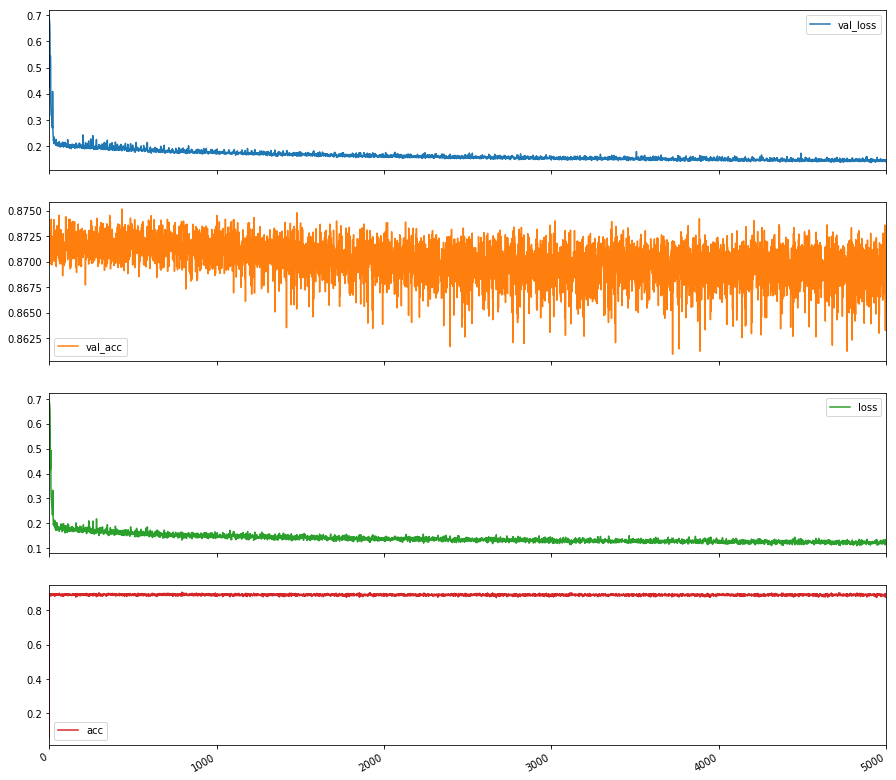

In [9]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,15))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<=0.1054]

##  Prediction

(7884, 64, 64, 1) (7884,)


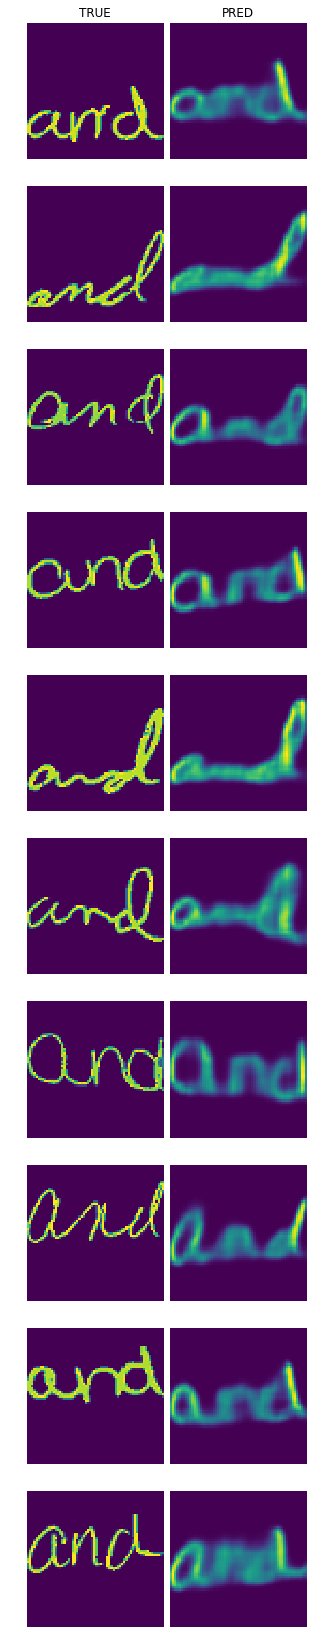

In [10]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)
test_g = datagen(len(val_list_of_writers)*4,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)
print(vx.shape,vy[0].shape)
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))

data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])

py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [11]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.63
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
for row in tqdm(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1

        if prev_query != queried_idx:

            queried_count += 1
        c_counter += 1
        prev_query = queried_idx

    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []

100%|██████████| 7884/7884 [3:47:54<00:00,  1.81s/it]  


In [12]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
df_cos_dist_out.to_csv('results_AutoEncoder_shuffled.csv')

total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.017091622808250936 
recall: 0.7571914580970787 
f1: 0.03342868032268721
Intra Writer Accuracy (Type 1): 0.7871230246631343
Inter Writer Accuracy (Type 2):: 0.9102633801486341
acc: 0.9117887643278089
